In [2]:
import pandas as pd
import numpy as np
import math

# =============================================================================
# 1. LOAD THE DATA
# =============================================================================
df = pd.read_csv('acndata_sessions.csv')

# =============================================================================
# 2. DATA CLEANING AND FILTERING
# =============================================================================

df.dropna(subset=['sessionID', 'connectionTime', 'disconnectTime'], inplace=True)

df['connectionTime'] = pd.to_datetime(df['connectionTime'], errors='coerce')
df['disconnectTime'] = pd.to_datetime(df['disconnectTime'], errors='coerce')
df.dropna(subset=['connectionTime', 'disconnectTime'], inplace=True)

df['session_duration'] = (df['disconnectTime'] - df['connectionTime']).dt.total_seconds() / 3600.0
df = df[df['session_duration'] > 0]
df = df[df['session_duration'] < 24]  # optional outlier removal

# ------------------------------------------------------------------------------
# 3. FEATURE ENGINEERING
# ------------------------------------------------------------------------------
df['start_time_hour'] = df['connectionTime'].dt.hour
df['day_of_week'] = df['connectionTime'].dt.dayofweek

def is_peak(hour):
    return 1 if hour in [7, 8, 9, 17, 18, 19] else 0

df['is_peak_hour'] = df['start_time_hour'].apply(is_peak)

policy_date = pd.to_datetime("2018-07-01")
df['after_new_pricing'] = (df['connectionTime'] >= policy_date).astype(int)
df['days_since_policy'] = (df['connectionTime'] - policy_date).dt.total_seconds() / 86400.0

df['date_hour'] = df['connectionTime'].dt.floor('h')

hourly_arrivals = (
    df.groupby(['stationID', 'date_hour'])['sessionID']
      .count()
      .reset_index(name='arrivals_count')
)
hourly_arrivals['arrival_rate'] = hourly_arrivals['arrivals_count'] * 1.0
df = pd.merge(df, hourly_arrivals, how='left', on=['stationID', 'date_hour'])

df['service_rate'] = df['kWhDelivered'] / df['session_duration']

service_stats = (
    df.groupby(['stationID', 'date_hour'])['service_rate']
      .mean()
      .reset_index(name='avg_service_rate_hourly')
)
df = pd.merge(df, service_stats, how='left', on=['stationID', 'date_hour'])

# ------------------------------------------------------------------------------
# 4. QUEUEING FEATURES (ERLANG-C) BEFORE SPLITTING
# ------------------------------------------------------------------------------
def erlang_c_waiting_time(arrival_rate, service_rate, s=2):
    """
    Compute the Erlang-C waiting probability and average waiting time (in hours).
    Replaces np.math with math.
    """
    if arrival_rate >= s * service_rate:
        # System is at/above capacity => infinite wait
        return 1.0, np.inf

    A = arrival_rate / service_rate
    rho = A / s

    sum_term = 0
    for k in range(s):
        sum_term += (A ** k) / math.factorial(k)

    denom_last = (A ** s) / math.factorial(s) * (1 / (1 - rho))
    denom_total = sum_term + denom_last

    P0 = 1 / denom_total
    P_all_busy = denom_last / denom_total  # Probability all servers busy
    P_wait = P_all_busy

    # Average waiting time in queue Wq
    if (s * service_rate - arrival_rate) > 0:
        Wq = P_wait / (s * service_rate - arrival_rate)
    else:
        Wq = np.inf

    return P_wait, Wq

erlang_results = []
for (st_id, hr), sub_df in df.groupby(['stationID', 'date_hour']):
    arrival_rate = sub_df['arrival_rate'].iloc[0]
    avg_sr = sub_df['avg_service_rate_hourly'].iloc[0]

    if avg_sr <= 0:
        p_wait, wq = 1.0, np.inf
    else:
        p_wait, wq = erlang_c_waiting_time(arrival_rate=arrival_rate,
                                           service_rate=avg_sr,
                                           s=2)
    erlang_results.append({
        'stationID': st_id,
        'date_hour': hr,
        'erlang_wait_prob': p_wait,
        'erlang_wait_time': wq
    })

erlang_df = pd.DataFrame(erlang_results)
df = pd.merge(df, erlang_df, on=['stationID', 'date_hour'], how='left')

# ------------------------------------------------------------------------------
# 5. REMOVE OR REPLACE INFINITES/NaNs BEFORE SCALING
# ------------------------------------------------------------------------------
# Option A: Replace inf with NaN and then drop them
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(subset=['erlang_wait_prob', 'erlang_wait_time'], inplace=True)

# ------------------------------------------------------------------------------
# 6. SPLIT THE DATA
# ------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split

features = [
    "start_time_hour",
    "day_of_week",
    "is_peak_hour",
    "after_new_pricing",
    "days_since_policy",
    "arrival_rate",
    "service_rate",
    "avg_service_rate_hourly",
    "erlang_wait_prob",
    "erlang_wait_time",
    "kWhDelivered"
]
target = "session_duration"

X = df[features].copy()
y = df[target].copy()

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.20, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42
)

print("Training set shape:   X_train =", X_train.shape, ", y_train =", y_train.shape)
print("Validation set shape: X_val   =", X_val.shape,   ", y_val =", y_val.shape)
print("Test set shape:       X_test  =", X_test.shape,   ", y_test =", y_test.shape)

# ------------------------------------------------------------------------------
# 7. SCALE (NORMALIZE) FEATURES FOR THE NN
# ------------------------------------------------------------------------------
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

# ------------------------------------------------------------------------------
# 8. NEURAL NETWORK WITH EARLY STOPPING
# ------------------------------------------------------------------------------
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping

model = models.Sequential([
    layers.Dense(32, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='linear')
])

model.compile(
    loss='mse',
    optimizer=optimizers.Adam(learning_rate=1e-3),
    metrics=['mae']
)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_scaled, y_val),
    callbacks=[early_stop],
    verbose=1
)

# Evaluate on Test Set
test_loss, test_mae = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"\n[NN] Test Loss (MSE): {test_loss:.4f}")
print(f"[NN] Test MAE:        {test_mae:.4f}")

# ------------------------------------------------------------------------------
# 9. DECISION TREE EXAMPLE (Optional)
# ------------------------------------------------------------------------------
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

dt_model = DecisionTreeRegressor(max_depth=5, min_samples_split=50, random_state=42)
dt_model.fit(X_train, y_train)

y_val_pred = dt_model.predict(X_val)
print(f"\n[DT] Validation MSE: {mean_squared_error(y_val, y_val_pred):.4f}")
print(f"[DT] Validation MAE: {mean_absolute_error(y_val, y_val_pred):.4f}")

y_test_pred = dt_model.predict(X_test)
print(f"[DT] Test MSE: {mean_squared_error(y_test, y_test_pred):.4f}")
print(f"[DT] Test MAE: {mean_absolute_error(y_test, y_test_pred):.4f}")


Training set shape:   X_train = (8450, 11) , y_train = (8450,)
Validation set shape: X_val   = (1056, 11) , y_val = (1056,)
Test set shape:       X_test  = (1057, 11) , y_test = (1057,)
Epoch 1/100


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 826us/step - loss: 27.4087 - mae: 3.8497 - val_loss: 2.7371 - val_mae: 1.1160
Epoch 2/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step - loss: 1.8977 - mae: 0.8608 - val_loss: 0.9662 - val_mae: 0.6349
Epoch 3/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 605us/step - loss: 0.8612 - mae: 0.5841 - val_loss: 0.5950 - val_mae: 0.5023
Epoch 4/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 624us/step - loss: 0.5506 - mae: 0.4705 - val_loss: 0.4281 - val_mae: 0.4311
Epoch 5/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 632us/step - loss: 0.4340 - mae: 0.4146 - val_loss: 0.3193 - val_mae: 0.3819
Epoch 6/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 605us/step - loss: 0.3377 - mae: 0.3640 - val_loss: 0.2541 - val_mae: 0.3336
Epoch 7/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 614us/step - loss: 0.2285 - mae: 0.3133 - val_loss: 0.2239 - val_mae: 0.3126
Epoch 8/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 603us/step - loss: 0.1995 - mae: 0.2889 - val_loss: 0.1818 - val_mae: 0.2754
Epoch 9/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step


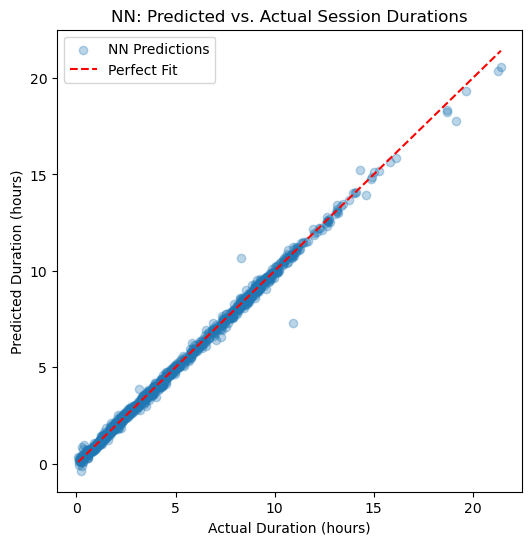

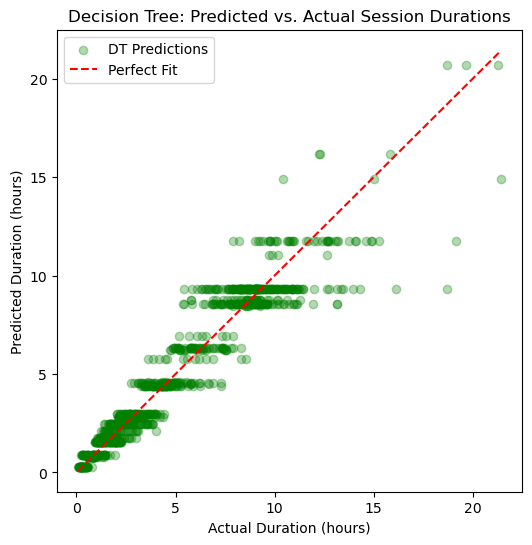

In [3]:
import matplotlib.pyplot as plt

# 1. Neural Network predictions
y_pred_nn = model.predict(X_test_scaled).flatten()  # model output might be a 2D array; flatten it
y_true = y_test.values  # convert to NumPy array if needed

plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred_nn, alpha=0.3, label='NN Predictions')
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', label='Perfect Fit')
plt.title("NN: Predicted vs. Actual Session Durations")
plt.xlabel("Actual Duration (hours)")
plt.ylabel("Predicted Duration (hours)")
plt.legend()
plt.show()

# 2. Decision Tree predictions
y_pred_dt = dt_model.predict(X_test)

plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred_dt, alpha=0.3, color='g', label='DT Predictions')
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', label='Perfect Fit')
plt.title("Decision Tree: Predicted vs. Actual Session Durations")
plt.xlabel("Actual Duration (hours)")
plt.ylabel("Predicted Duration (hours)")
plt.legend()
plt.show()


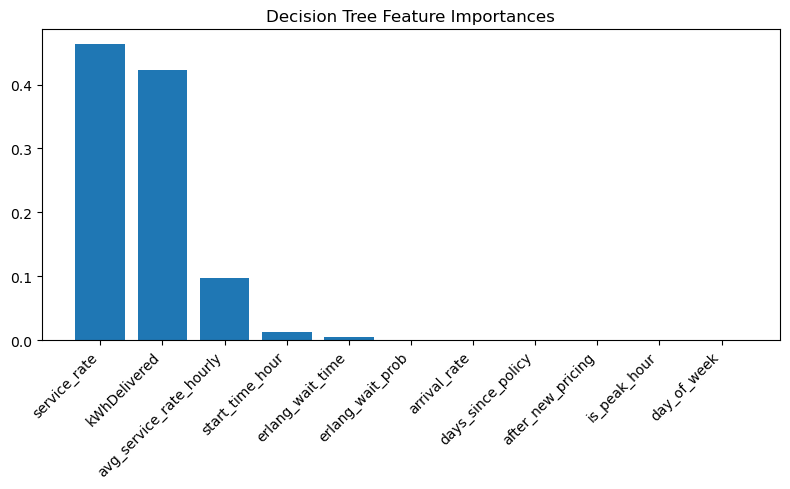

In [4]:
import numpy as np

importances = dt_model.feature_importances_
feature_names = X_train.columns
indices = np.argsort(importances)[::-1]  # sort descending

plt.figure(figsize=(8, 5))
plt.title("Decision Tree Feature Importances")
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45, ha='right')
plt.tight_layout()
plt.show()


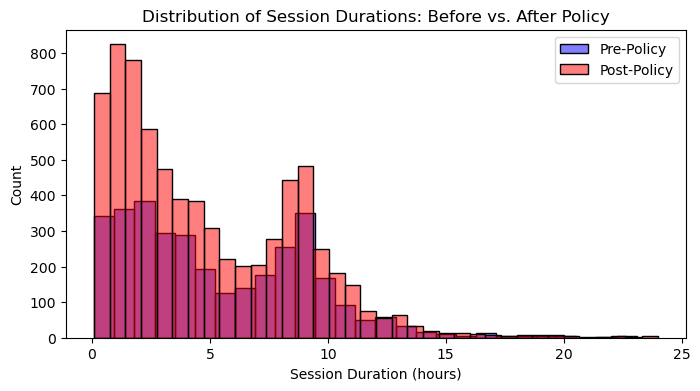

In [5]:
import seaborn as sns

df_pre  = df[df['after_new_pricing'] == 0]
df_post = df[df['after_new_pricing'] == 1]

plt.figure(figsize=(8,4))
sns.histplot(df_pre['session_duration'], color='blue', alpha=0.5, label='Pre-Policy')
sns.histplot(df_post['session_duration'], color='red', alpha=0.5, label='Post-Policy')
plt.title("Distribution of Session Durations: Before vs. After Policy")
plt.xlabel("Session Duration (hours)")
plt.ylabel("Count")
plt.legend()
plt.show()


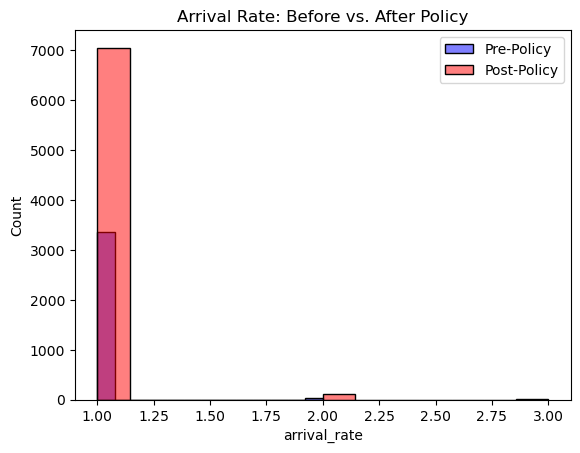

In [7]:
plt.figure()
sns.histplot(df_pre['arrival_rate'], color='blue', alpha=0.5, label='Pre-Policy')
sns.histplot(df_post['arrival_rate'], color='red', alpha=0.5, label='Post-Policy')
plt.title("Arrival Rate: Before vs. After Policy")
plt.legend()
plt.show()
